In [2]:
import os
import glob
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [4]:
import utils

In [5]:
# Define dataset.
# dataset_name = 'cifar_10'
# dataset_name = 'svhn'
# dataset_name = 'fashion_mnist'
# dataset_dir = '../datasets/' + dataset_name
# train_dir = os.path.join(dataset_dir, 'train')


dataset_name = 'sars_cov_2_ct_scan'
dataset_dir = '../datasets/' + dataset_name
train_dir = os.path.join(dataset_dir)

In [6]:
class_labels = os.listdir(train_dir)
class_labels.sort()
print(class_labels)

['covid', 'non_covid']


In [7]:
# Read image list into a dictionary for each class.
train_img_dict = {}
for class_label in class_labels:
    class_folder = os.path.join(train_dir, class_label)
    img_list = glob.glob(os.path.join(class_folder, '*.JPG')) + glob.glob(os.path.join(class_folder, '*.jpg')) + glob.glob(os.path.join(class_folder, '*.png'))           
    train_img_dict[class_label] = img_list
    print(class_label, ':', len(img_list))

covid : 1252
non_covid : 1229


In [8]:
def get_dirichlet_proportions(beta, num_clients, num_total_samples):
    rng = np.random.default_rng()
    proportions = rng.dirichlet(np.repeat(beta, num_clients))
    proportions = proportions / proportions.sum()
    proportions = np.round(proportions * num_total_samples).astype(int)[:-1]
    proportions = np.append(proportions, max(0, num_total_samples - sum(proportions)))           # For the last client.
    return proportions

In [9]:
# Define distribution settings.
num_clients = 10            # [10, 30, 50]
beta = 0.5 # [0.1, 0.5, 5]

client_data_dir = os.path.join('./client_data/', dataset_name + '_b_{}_c_{}'.format(beta, num_clients))

In [10]:
data_notes = {}

for class_label in class_labels:

    sample_list = train_img_dict[class_label]
    random.shuffle(sample_list)
    num_total_samples = len(sample_list)
    
    proportions = get_dirichlet_proportions(beta, num_clients, num_total_samples)
    print('{:>12} : {}'.format(class_label, proportions))
    
    start_idx = 0
    for client_idx in range(num_clients):
        end_idx = start_idx + proportions[client_idx]
        dest_dir = os.path.join(client_data_dir, str(client_idx), class_label)
        os.makedirs(dest_dir)
        for img in sample_list[start_idx:end_idx]:
            shutil.copy(img, dest_dir)
        start_idx = end_idx
        data_notes.setdefault(client_idx, {})
        data_notes[client_idx][class_label] = proportions[client_idx]

       covid : [ 20 140 441  66  19   1  14 183 339  29]
   non_covid : [187 105   4  10  14 289  24  24 572   0]


In [11]:
for client_idx in range(num_clients):
    note_file = os.path.join(os.path.join(client_data_dir, str(client_idx), 'notes.txt'))
    txt = ''
    for class_label, num_samples in data_notes[client_idx].items():
        buff = '{:15} : {}\n'.format(class_label, num_samples)
        txt += buff
    utils.save_notes(note_file, txt)

In [12]:
mat = np.zeros((num_clients, len(class_labels)))

x, y, n = [], [], []
for idx in range(num_clients):
    client_dir = os.path.join(client_data_dir, str(idx))
    for class_idx, label in enumerate(class_labels):
        class_dir = os.path.join(client_dir, label)
        if os.path.exists(class_dir):
            n.append((1*len(os.listdir(class_dir)))**1)
            mat[idx][class_idx] = len(os.listdir(class_dir))
        else:
            n.append(0)
            mat[idx][class_idx] = 0
        y.append(label)
        x.append(idx)

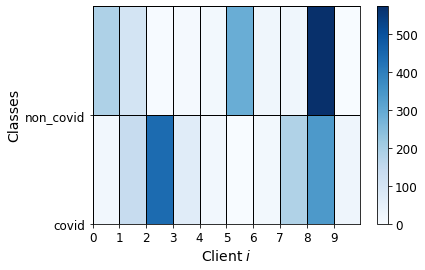

In [13]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()

im = ax.pcolormesh(np.transpose(mat), edgecolors='k', linewidth=1, cmap=plt.get_cmap('Blues'))
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=12)

ax.set_xlabel('Client $i$', fontsize=14)
ax.set_ylabel('Classes', fontsize=14)

yticks = class_labels

ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks)  

ax.set_xticks(range(num_clients))

ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
plt.savefig(os.path.join(client_data_dir, 'client_data_amount.png'), dpi=300, bbox_inches='tight')
plt.show()